In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [2]:
import os
import numpy as np
import pandas as pd

from os import listdir
from io import BytesIO
import requests

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models,utils
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models

from scipy import stats
from sklearn import preprocessing

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

import PIL
from PIL import Image

from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("white")

In [3]:
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Please install GPU version of TF


In [4]:
DATA_DIR = 'data/caps and shoes/'

In [5]:
def convert_img_to_data(image):
    data = np.asarray(image)
    gs_image = image.convert(mode='L')
    gs_data = np.asarray(gs_image)
    gs_resized = gs_image.resize((112,112))
    gs_resized_data = np.asarray(gs_resized)
    reshaped_gs_data = gs_resized_data.reshape(112*112)
    return reshaped_gs_data

def convert_images_from_dir(dir_path):
    image_data = []
    
    for filename in listdir(dir_path):
        image = Image.open(dir_path +os.sep + filename)
        reshaped_gs_data = convert_img_to_data(image)
        image_data.append(reshaped_gs_data)
    
    return image_data

def load_from_dir(dir_path, labels):
    label_data = []
    image_data = []
    for label in labels:
        data_from_dir = convert_images_from_dir(dir_path + label)
        labels_for_data = [label for i in range(len(data_from_dir))]
        image_data += data_from_dir
        label_data += labels_for_data
    
    print('Found %d images belonging to %d classes' % (len(image_data),  len(labels)))
    return (np.array(image_data),np.array(label_data))

def load_img_data(data_dir):
    train_dir = DATA_DIR + 'train/'
    validation_dir = DATA_DIR + 'val/'
    test_dir = DATA_DIR + 'test/'
    
    if (os.path.isdir(train_dir) and os.path.isdir(validation_dir) and os.path.isdir(test_dir)) :
        labels = [subdirname.name for subdirname in os.scandir(train_dir) if subdirname.is_dir()] 
        
        train_data = load_from_dir(train_dir,labels)
        validation_data = load_from_dir(validation_dir,labels)
        test_data = load_from_dir(test_dir,labels)
        
    return train_data, validation_data, test_data     

def url_to_image(img_url):
    response = requests.get(img_url)
    img = Image.open(BytesIO(response.content))
    return img

def plot_images(ims, figsize=(24,12), rows=1, interp=False, titles=None):
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=18)
        
        plt.imshow(ims[i].reshape(112,112), cmap="gray")

In [6]:
train_data, validation_data, test_data = load_img_data(DATA_DIR)
X_train, y_train = train_data
X_val, y_val = validation_data
X_test, y_test = test_data

Found 200 images belonging to 2 classes
Found 100 images belonging to 2 classes
Found 50 images belonging to 2 classes


In [7]:
print('X_train shape : %s' % str(X_train.shape))
print('y_train shape : %s' % str(y_train.shape))
print('X_val shape : %s' % str(X_val.shape))
print('y_val shape : %s' % str(y_val.shape))
print('X_test shape : %s' % str(X_test.shape))
print('y_test shape : %s' % str(y_test.shape))

X_train shape : (200, 12544)
y_train shape : (200,)
X_val shape : (100, 12544)
y_val shape : (100,)
X_test shape : (50, 12544)
y_test shape : (50,)


In [8]:
X_train = X_train.astype('float32') / 255
X_val = X_val.astype('float32') / 255
X_test = X_test.astype('float32') / 255

In [9]:
le = preprocessing.LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)
y_val = le.transform(y_val)
y_test = le.transform(y_test)
y_train = utils.to_categorical(y_train)
y_val = utils.to_categorical(y_val)
y_test = utils.to_categorical(y_test)

In [10]:
print('y_train shape : %s' % str(y_train.shape))
print('y_val shape : %s' % str(y_val.shape))
print('y_test shape : %s' % str(y_test.shape))

y_train shape : (200, 2)
y_val shape : (100, 2)
y_test shape : (50, 2)


In [11]:
def define_model_architecture():
    model = models.Sequential()
    model.add(Dense(32, activation='relu', input_shape=(12544,)))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    
    model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [12]:
model = define_model_architecture()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                401440    
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 34        
Total params: 402,002
Trainable params: 402,002
Non-trainable params: 0
_________________________________________________________________


In [13]:
%time history = model.fit(X_train, y_train, validation_data = (X_val,y_val), epochs=125, batch_size=200, shuffle=True)

W0805 21:55:41.528681 140625143957312 deprecation.py:323] From /home/algolaptop8/anaconda3/envs/tf2-env/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 200 samples, validate on 100 samples
Epoch 1/125
200/200 [==============================] - 0s 571us/sample - loss: 1.0103 - accuracy: 0.5000 - val_loss: 0.7167 - val_accuracy: 0.5000
Epoch 2/125
200/200 [==============================] - 0s 60us/sample - loss: 0.7220 - accuracy: 0.5000 - val_loss: 0.6938 - val_accuracy: 0.5300
Epoch 3/125
200/200 [==============================] - 0s 53us/sample - loss: 0.6986 - accuracy: 0.4050 - val_loss: 0.6911 - val_accuracy: 0.6000
Epoch 4/125
200/200 [==============================] - 0s 68us/sample - loss: 0.6959 - accuracy: 0.4350 - val_loss: 0.6883 - val_accuracy: 0.6300
Epoch 5/125
200/200 [==============================] - 0s 43us/sample - loss: 0.6931 - accuracy: 0.4700 - val_loss: 0.6858 - val_accuracy: 0.6400
Epoch 6/125
200/200 [==============================] - 0s 48us/sample - loss: 0.6906 - accuracy: 0.5400 - val_loss: 0.6835 - val_accuracy: 0.6500
Epoch 7/125
200/200 [==============================] - 0s 48us/sample - loss:

Epoch 57/125
200/200 [==============================] - 0s 43us/sample - loss: 0.6064 - accuracy: 0.7100 - val_loss: 0.5915 - val_accuracy: 0.6600
Epoch 58/125
200/200 [==============================] - 0s 42us/sample - loss: 0.5942 - accuracy: 0.6600 - val_loss: 0.6106 - val_accuracy: 0.7000
Epoch 59/125
200/200 [==============================] - 0s 44us/sample - loss: 0.6026 - accuracy: 0.7150 - val_loss: 0.5855 - val_accuracy: 0.6600
Epoch 60/125
200/200 [==============================] - 0s 41us/sample - loss: 0.5875 - accuracy: 0.6950 - val_loss: 0.5984 - val_accuracy: 0.7300
Epoch 61/125
200/200 [==============================] - 0s 47us/sample - loss: 0.5899 - accuracy: 0.7350 - val_loss: 0.5760 - val_accuracy: 0.6700
Epoch 62/125
200/200 [==============================] - 0s 53us/sample - loss: 0.5746 - accuracy: 0.7100 - val_loss: 0.5881 - val_accuracy: 0.7300
Epoch 63/125
200/200 [==============================] - 0s 40us/sample - loss: 0.5787 - accuracy: 0.7400 - val_loss: 0

Epoch 113/125
200/200 [==============================] - 0s 47us/sample - loss: 0.5393 - accuracy: 0.7550 - val_loss: 0.5461 - val_accuracy: 0.6800
Epoch 114/125
200/200 [==============================] - 0s 43us/sample - loss: 0.5305 - accuracy: 0.7350 - val_loss: 0.5645 - val_accuracy: 0.7300
Epoch 115/125
200/200 [==============================] - 0s 43us/sample - loss: 0.5350 - accuracy: 0.7500 - val_loss: 0.5439 - val_accuracy: 0.6900
Epoch 116/125
200/200 [==============================] - 0s 38us/sample - loss: 0.5275 - accuracy: 0.7300 - val_loss: 0.5617 - val_accuracy: 0.7300
Epoch 117/125
200/200 [==============================] - 0s 47us/sample - loss: 0.5315 - accuracy: 0.7500 - val_loss: 0.5419 - val_accuracy: 0.7000
Epoch 118/125
200/200 [==============================] - 0s 37us/sample - loss: 0.5246 - accuracy: 0.7300 - val_loss: 0.5629 - val_accuracy: 0.7300
Epoch 119/125
200/200 [==============================] - 0s 47us/sample - loss: 0.5315 - accuracy: 0.7600 - val_

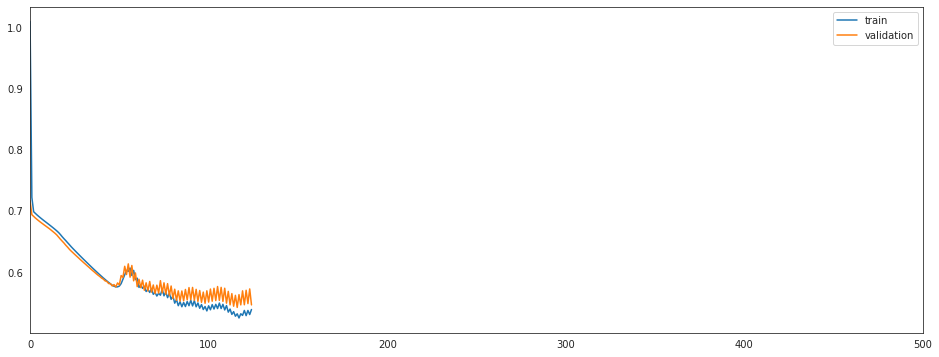

In [14]:
plt.figure(num=None, figsize=(16, 6))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.xlim(0, 500)
plt.show()

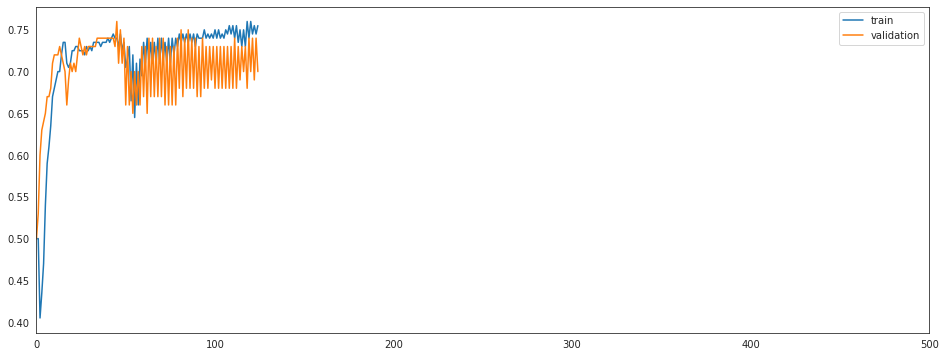

In [15]:
plt.figure(num=None, figsize=(16, 6))
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.xlim(0, 500)
plt.show()

In [16]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=50) 
print('Test loss: %.4f accuracy: %.4f' % (test_loss, test_accuracy))

50/50 [==============================] - 0s 384us/sample - loss: 0.5494 - accuracy: 0.6400
Test loss: 0.5494 accuracy: 0.6400


In [17]:
layers_info = {}
for i in model.layers:
    layers_info[i.name] = i.get_config()

layer_weights = {}
for i in model.layers:
    layer_weights[i.name] = i.get_weights()

In [18]:
layers_info

{'dense': {'name': 'dense',
  'trainable': True,
  'batch_input_shape': (None, 12544),
  'dtype': 'float32',
  'units': 32,
  'activation': 'relu',
  'use_bias': True,
  'kernel_initializer': {'class_name': 'GlorotUniform',
   'config': {'seed': None}},
  'bias_initializer': {'class_name': 'Zeros', 'config': {}},
  'kernel_regularizer': None,
  'bias_regularizer': None,
  'activity_regularizer': None,
  'kernel_constraint': None,
  'bias_constraint': None},
 'dense_1': {'name': 'dense_1',
  'trainable': True,
  'dtype': 'float32',
  'units': 16,
  'activation': 'relu',
  'use_bias': True,
  'kernel_initializer': {'class_name': 'GlorotUniform',
   'config': {'seed': None}},
  'bias_initializer': {'class_name': 'Zeros', 'config': {}},
  'kernel_regularizer': None,
  'bias_regularizer': None,
  'activity_regularizer': None,
  'kernel_constraint': None,
  'bias_constraint': None},
 'dense_2': {'name': 'dense_2',
  'trainable': True,
  'dtype': 'float32',
  'units': 2,
  'activation': 'soft

In [19]:
for cnt,layer in enumerate(model.layers):
    print('Layer : %d'%cnt)
    print('Layer weight shape : %s' % str(layer.get_weights()[0].shape))
    print('Layer bias shape : %s' % str(layer.get_weights()[1].shape))

Layer : 0
Layer weight shape : (12544, 32)
Layer bias shape : (32,)
Layer : 1
Layer weight shape : (32, 16)
Layer bias shape : (16,)
Layer : 2
Layer weight shape : (16, 2)
Layer bias shape : (2,)


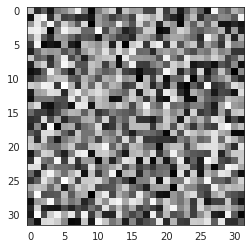

In [20]:
plt.imshow(model.layers[0].get_weights()[0][:32],cmap='gray')

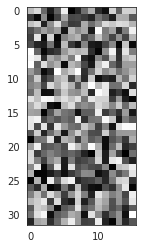

In [21]:
plt.imshow(model.layers[1].get_weights()[0],cmap='gray')

In [22]:
layer_0_weights = model.layers[0].get_weights()[0].flatten()
layer_1_weights = model.layers[1].get_weights()[0].flatten()
layer_2_weights = model.layers[2].get_weights()[0].flatten()

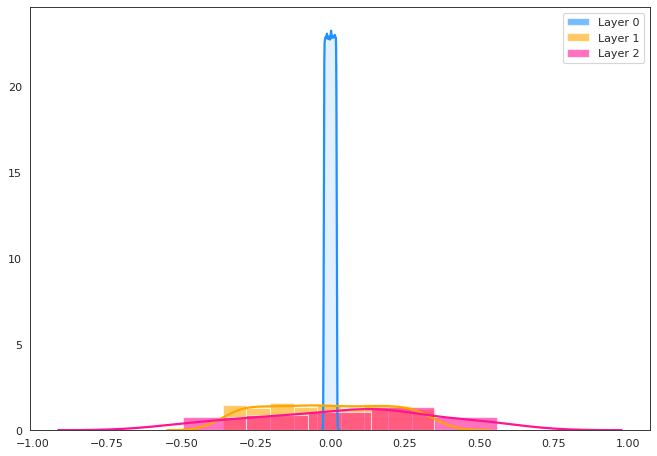

In [23]:
kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})

plt.figure(figsize=(10,7), dpi= 80)
sns.distplot(layer_0_weights, color="dodgerblue", label="Layer 0", **kwargs)
sns.distplot(layer_1_weights, color="orange", label="Layer 1", **kwargs)
sns.distplot(layer_2_weights, color="deeppink", label="Layer 2", **kwargs)
plt.legend();

In [24]:
layer_0_bias = model.layers[0].get_weights()[1].flatten()
layer_1_bias = model.layers[1].get_weights()[1].flatten()
layer_2_bias = model.layers[2].get_weights()[1].flatten()

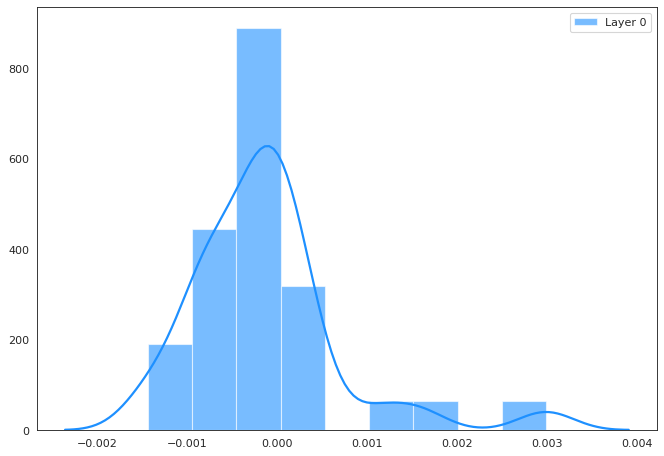

In [25]:
kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})

plt.figure(figsize=(10,7), dpi= 80)
sns.distplot(layer_0_bias, color="dodgerblue", label="Layer 0", **kwargs)
#sns.distplot(layer_1_bias, color="orange", label="Layer 1", **kwargs)
#sns.distplot(layer_2_bias, color="deeppink", label="Layer 2", **kwargs)
plt.legend();

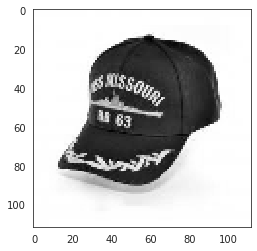

In [26]:
example_ix = 22
image_2d_array = X_train[example_ix].reshape(112,112)
imshow(image_2d_array,cmap="gray")

In [27]:
layer_outputs = [layer.output for layer in model.layers]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(X_train[example_ix].reshape(1,112*112))

(1, 32)


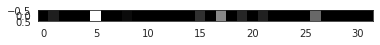

In [28]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)
imshow(first_layer_activation, cmap='gray')

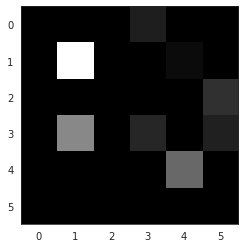

In [29]:
first_layer_activation_img = np.pad(first_layer_activation[0], (2, 2), 'constant').reshape(6,6)
imshow(first_layer_activation_img,cmap="gray")

(1, 16)


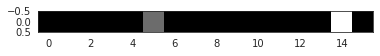

In [30]:
second_layer_activation = activations[1]
print(second_layer_activation.shape)
imshow(second_layer_activation, cmap='gray')

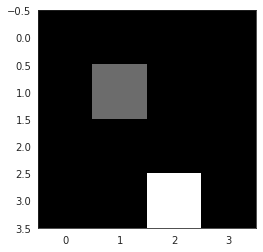

In [31]:
second_layer_activation_img = second_layer_activation[0].reshape(4,4)
imshow(second_layer_activation_img,cmap="gray")

(1, 2)
[[0.9417131  0.05828689]]


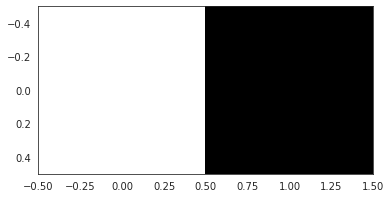

In [32]:
third_layer_activation = activations[2]
print(third_layer_activation.shape)
print(third_layer_activation)
imshow(third_layer_activation, cmap='gray')

/home/algolaptop8/anaconda3/envs/tf2-env/lib/python3.7/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
[[0.6295903  0.37040976]]


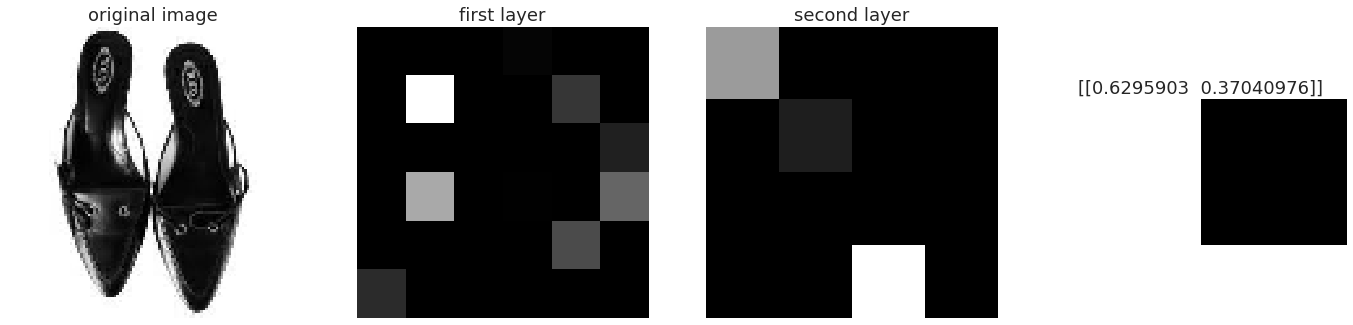

In [33]:
example_ix = 123
image_2d_array = X_train[example_ix].reshape(112,112)

layer_outputs = [layer.output for layer in model.layers]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(X_train[example_ix].reshape(1,112*112))

first_layer_activation_img = np.pad(activations[0][0], (2, 2), 'constant').reshape(6,6)
second_layer_activation_img = activations[1][0].reshape(4,4)
third_layer_activation = activations[2]

ims = [image_2d_array,first_layer_activation_img,second_layer_activation_img,third_layer_activation]
titles = ['original image', 'first layer', 'second layer', third_layer_activation]

f = plt.figure(figsize=(24,12))
rows = 1
cols = 4

for i in range(len(ims)):
    sp = f.add_subplot(rows, cols, i+1)
    sp.axis('Off')
    sp.set_title(titles[i], fontsize=18)
    plt.imshow(ims[i], cmap="gray")
    
print('~'*120)
print(third_layer_activation)